# Notebook project about testing SAM to segment Cardiac MRI scans

"This preprocessed dataset, derived from the Automated Cardiac Diagnosis Challenge (ACDC), is meticulously curated for cardiac image segmentation endeavors, with a primary focus on delineating the left ventricle (LV), right ventricle (RV), and myocardium (MYO). Additionally, this dataset is complemented by detailed scribble annotations, providing a valuable resource for scribble-supervised learning—a method crucial for weakly supervised learning approaches." [Kaggle link](https://www.kaggle.com/datasets/anhoangvo/acdc-dataset/data)

In order to take ideas about how to use SAM on this segmentation task and to apply fine tuning, I analysed this [paper](https://arxiv.org/pdf/2312.08932)

## Google Colab configuration

In [24]:
!git clone https://github.com/Silvano315/Med-Physics.git

Cloning into 'Med-Physics'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 88 (delta 33), reused 59 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 5.39 MiB | 6.62 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [25]:
# change working directory

import os

os.chdir("Med-Physics")
os.getcwd()

'/content/Med-Physics/Med-Physics'

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Copy your Kaggle API to /root/.config/kaggle and /root/.kaggle/kaggle.json

os.makedirs('/root/.kaggle', exist_ok = True)

!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.config/kaggle.json
!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.kaggle/kaggle.json

In [28]:
# Install requirements

!pip install segment_anything

## Import Libraries

In [ ]:
# If you're running this repository LOCALLY, RUN this cell:

import os
os.chdir("..")
os.getcwd()

'/Users/silvanoquarto/Desktop/LAVORO/MEDICAL_PHYSICS/Med-Physics'

In [29]:
# Import libraries

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import SamPredictor
from typing import List, Dict, Optional

from src.src_ACDC_ds.utils.downloader import download_kaggle_dataset
from src.src_ACDC_ds.data.data_precessing import list_h5_files, create_dataset_info, load_h5_data, \
                                                    get_points_from_scribble_only
from src.src_ACDC_ds.data.data_viz import plot_slice_with_mask, plot_volume_slices, volume_slider, visualize_points, \
                                            visualize_results
from src.src_ACDC_ds.model.sam_model import setup_sam, segment_with_sam

## Setup and Configuration

In [30]:
# Set up device to use

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [31]:
# Create directories

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

## Download dataset

In [32]:
# Download ACDC dataset from Kaggle using API key

download_kaggle_dataset(dataset_name="ACDC", kaggle_url='anhoangvo/acdc-dataset')

Dataset URL: https://www.kaggle.com/datasets/anhoangvo/acdc-dataset
Dataset downloaded and extracted successfully!


## Cardiac MRI Segmentation with SAM - Exploratory Analysis

In [ ]:
sam = setup_sam()
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Data Loading & Preprocessing

In [15]:
training_volumes_files = list_h5_files(data_dir, 'training_volumes')
training_slices_files = list_h5_files(data_dir, 'training_slices')
testing_volumes_files = list_h5_files(data_dir, 'testing')

print(f"Found {len(training_slices_files)} training slises \
and {len(training_volumes_files)} training volumes files \
and {len(testing_volumes_files)} testing volumes files")

Found 1912 training slises and 200 training volumes files and 100 testing volumes files


In [16]:
file_lists = {
        'training_volumes': training_volumes_files,
        'training_slices': training_slices_files,
        'testing_volumes': testing_volumes_files
    }

dataset_df = create_dataset_info(file_lists)
print("\nDataset Overview:")
dataset_df


Dataset Overview:


patient_id  frame  slice             type  \
1898           1      1    0.0  training_slices   
2040           1      1    1.0  training_slices   
641            1      1    2.0  training_slices   
1263           1      1    2.0  training_slices   
1020           1      1    3.0  training_slices   
...          ...    ...    ...              ...   
2162         148     10    NaN  testing_volumes   
2174         149      1    NaN  testing_volumes   
2197         149     12    NaN  testing_volumes   
2160         150      1    NaN  testing_volumes   
2189         150     12    NaN  testing_volumes   

                                                   path  
1898  data/ACDC_preprocessed/ACDC_training_slices/pa...  
2040  data/ACDC_preprocessed/ACDC_training_slices/pa...  
641   data/ACDC_preprocessed/ACDC_training_slices/pa...  
1263  data/ACDC_preprocessed/ACDC_training_slices/pa...  
1020  data/ACDC_preprocessed/ACDC_training_slices/pa...  
...                                                 ...  
2162  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2174  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2197  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2160  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  
2189  data/ACDC_preprocessed/ACDC_testing_volumes/pa...  

[2212 rows x 5 columns]

In [17]:
print("Dataset Statistics:")
print(f"Total files: {len(dataset_df)}")
print("\nFiles per type:")
print(dataset_df['type'].value_counts())
print("\nUnique patients:", dataset_df['patient_id'].nunique())

Dataset Statistics:
Total files: 2212

Files per type:
type
training_slices     1912
training_volumes     200
testing_volumes      100
Name: count, dtype: int64

Unique patients: 150


In [18]:
if training_volumes_files:
        sample_data = load_h5_data(training_volumes_files[0])

sample_data['image'], sample_data['label'], sample_data['scribble']

Available keys in patient063_frame16.h5: ['image', 'label', 'scribble']


(array([[[0.        , 0.        , 0.        , ..., 0.00170068,
          0.0042517 , 0.00510204],
         [0.        , 0.00255102, 0.00170068, ..., 0.        ,
          0.0042517 , 0.00510204],
         [0.        , 0.00510204, 0.00085034, ..., 0.00255102,
          0.00340136, 0.00510204],
         ...,
         [0.        , 0.0042517 , 0.0085034 , ..., 0.01445578,
          0.0297619 , 0.01105442],
         [0.        , 0.00765306, 0.00935374, ..., 0.02806122,
          0.02040816, 0.0170068 ],
         [0.        , 0.00935374, 0.00680272, ..., 0.01105442,
          0.00510204, 0.00340136]],
 
        [[0.00595238, 0.00510204, 0.00170068, ..., 0.        ,
          0.        , 0.        ],
         [0.0042517 , 0.00765306, 0.00340136, ..., 0.        ,
          0.        , 0.        ],
         [0.00340136, 0.0085034 , 0.00680272, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.0085034 , 0.00170068, 0.00595238, ..., 0.        ,
          0.        , 0.

In [21]:
np.unique(sample_data['label']), np.unique(sample_data['scribble'])

(array([0, 1, 2, 3], dtype=uint8), array([0, 1, 2, 3, 4], dtype=uint16))

In [22]:
sample_data['image'].shape, sample_data['label'].shape, sample_data['scribble'].shape

((8, 176, 256), (8, 176, 256), (8, 176, 256))

### Visualize 2D-3D MRI images with labels and scribbles

Available keys in patient030_frame01_slice_7.h5: ['image', 'label', 'scribble']


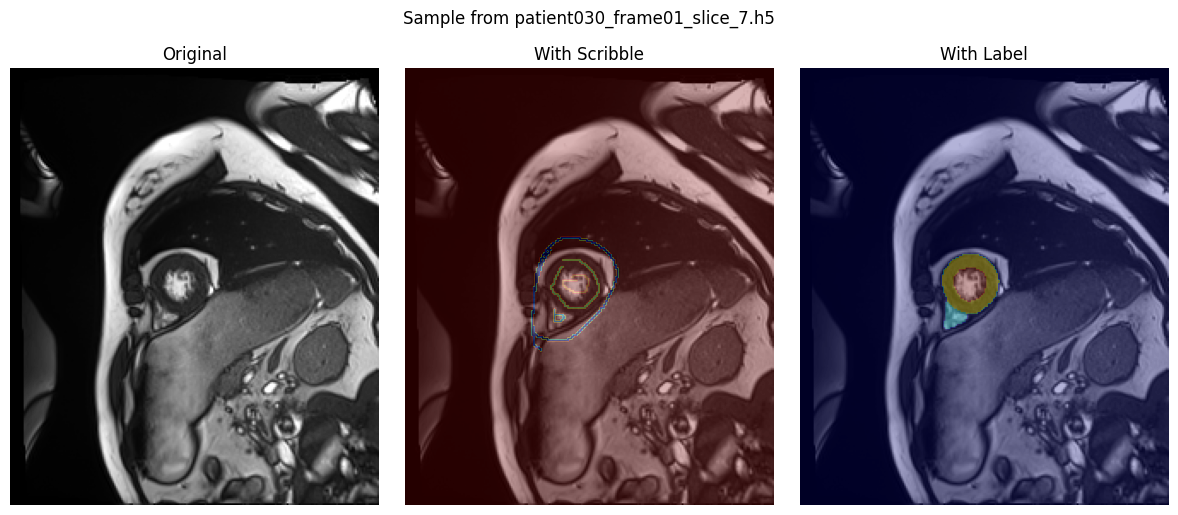

In [ ]:
if training_slices_files:
  sample = np.random.randint(0, len(training_slices_files))
  sample_data = load_h5_data(training_slices_files[sample])

  if len(sample_data['image'].shape) == 3:
      middle_slice = sample_data['image'].shape[2] // 2
      image_slice = sample_data['image'][:, :, middle_slice]
      mask_slice = sample_data['scribble'][:, :, middle_slice] if 'scribble' in sample_data else None
  else:
      image_slice = sample_data['image']
      mask_slice = sample_data['scribble'] if 'scribble' in sample_data else None

plot_slice_with_mask(image_slice, sample_data['label'], mask_slice,
                      f"Sample from {Path(training_slices_files[sample]).name}")

Available keys in patient012_frame01.h5: ['image', 'label', 'scribble']


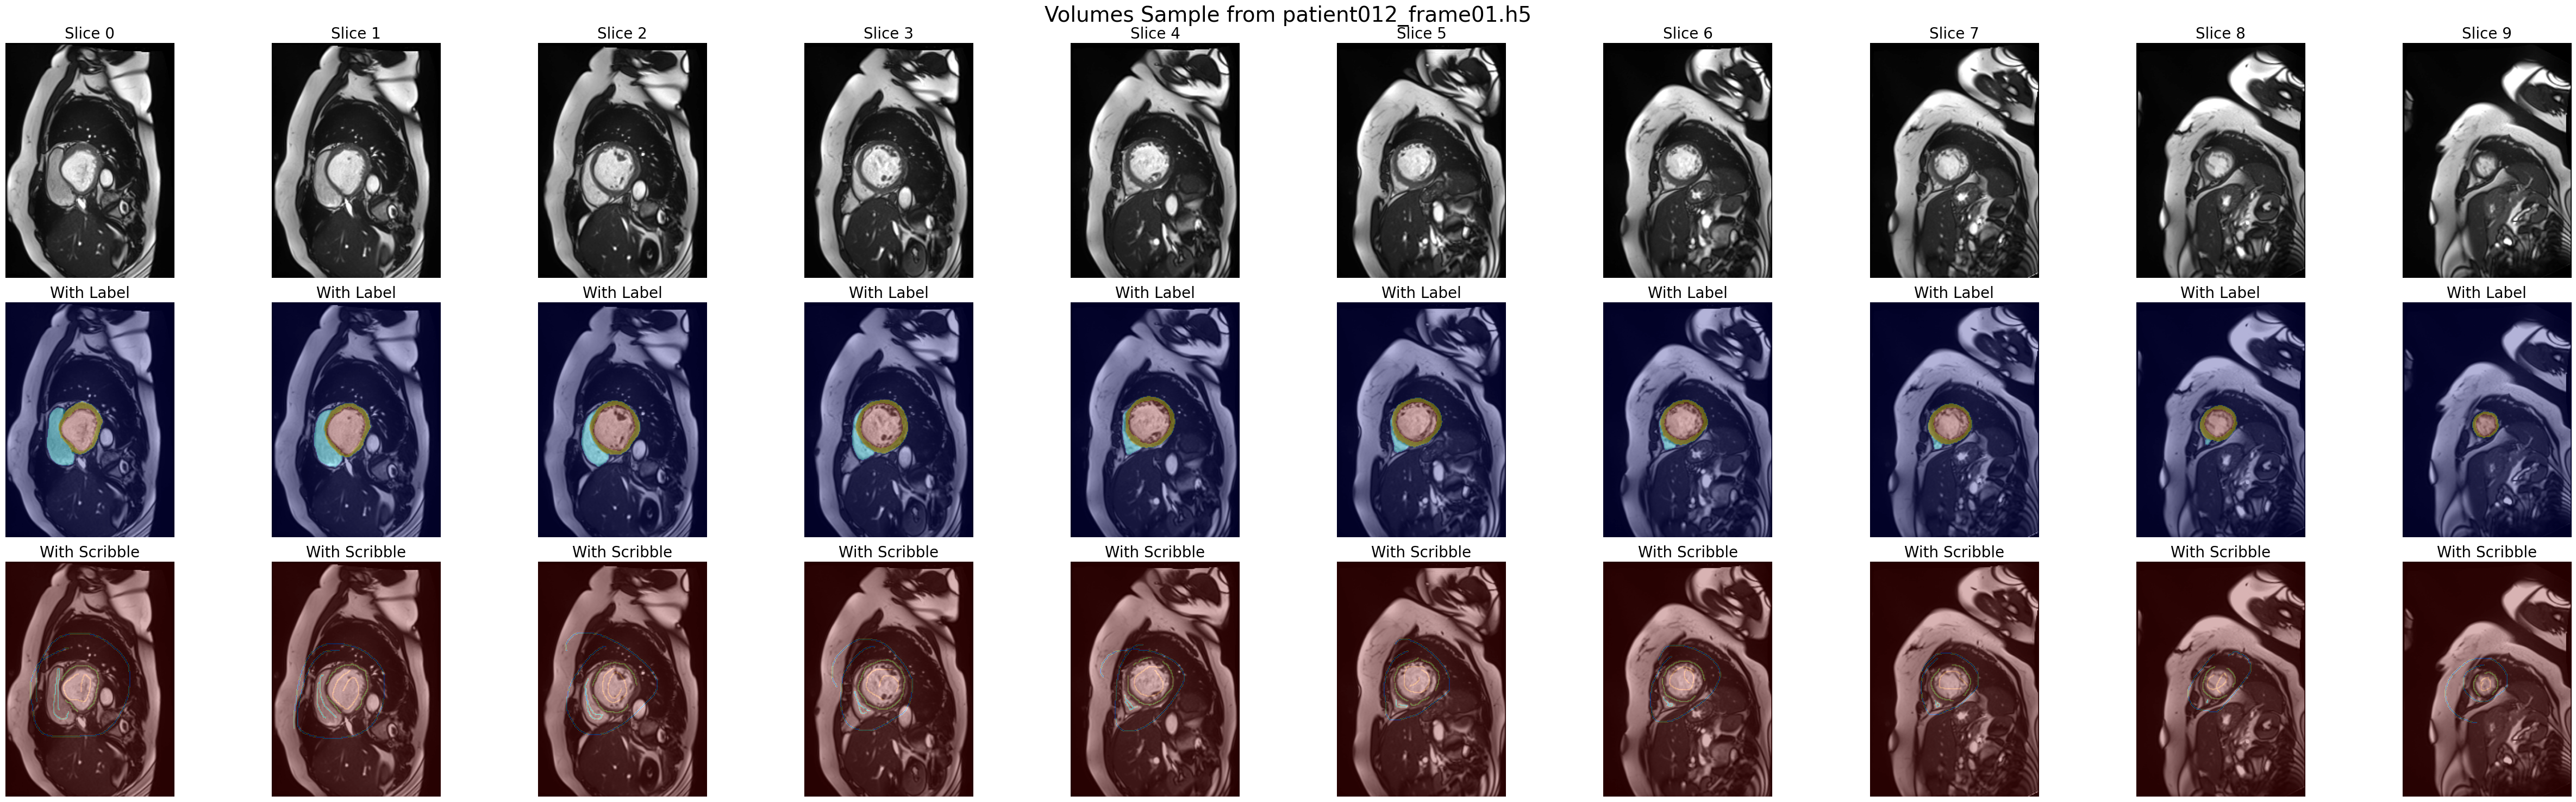

In [ ]:
if training_volumes_files:
  sample = np.random.randint(0, len(training_volumes_files))
  sample_data = load_h5_data(training_volumes_files[sample])

plot_volume_slices(sample_data['image'], label = sample_data['label'],
                   scribble = sample_data['scribble'] if 'scribble' in sample_data else None,
                   start_slice = 0,
                   num_slices = sample_data['image'].shape[0],
                   title = f"Volumes Sample from {Path(training_volumes_files[sample]).name}")

In [ ]:
volume_slider(sample_data['image'], sample_data['label'])

## SAM with Zero-Shot Generalization starting from the Scribble

Available keys in patient013_frame14_slice_1.h5: ['image', 'label', 'scribble']


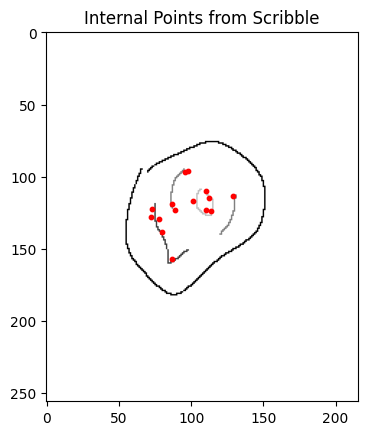

In [ ]:
sample = np.random.randint(0, len(training_slices_files))
sample_data = load_h5_data(training_slices_files[sample])
scribble = sample_data['scribble']

internal_points, _ = get_points_from_scribble_only(scribble, n_points_per_class = 5)

plt.imshow(scribble, cmap='gray')
plt.scatter(internal_points[:, 0], internal_points[:, 1], color='red', s=10)
plt.title("Internal Points from Scribble")
plt.show()

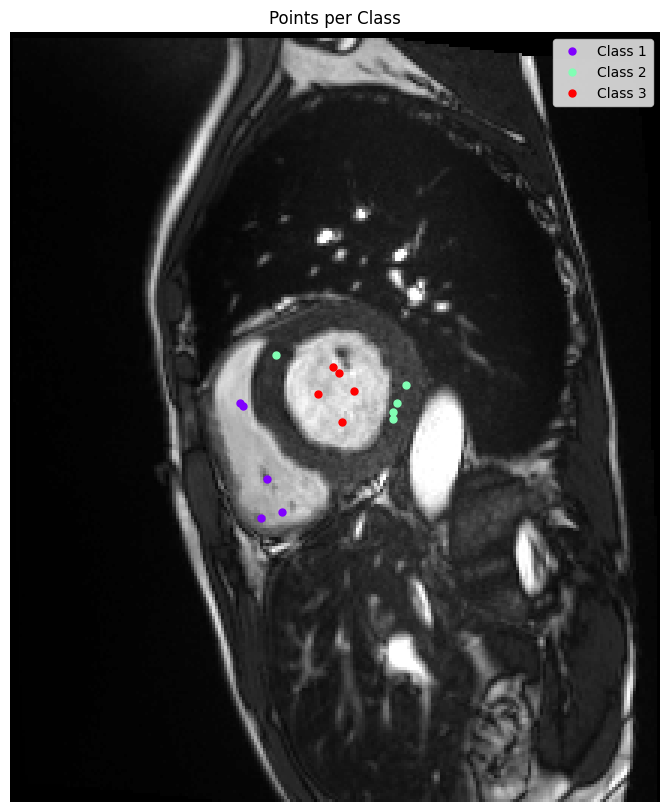

In [ ]:
points, point_labels = get_points_from_scribble_only(scribble, n_points_per_class = 5)
visualize_points(sample_data['image'], points, point_labels)

In [ ]:
# Set up SAM model

sam = setup_sam()
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


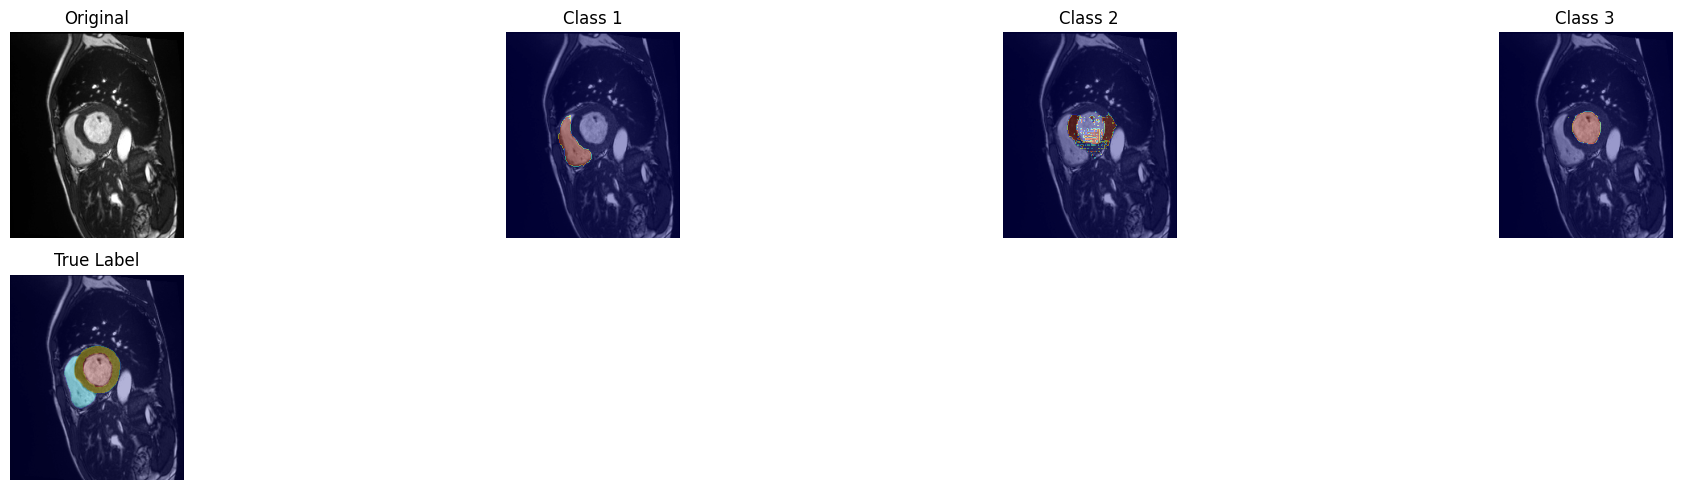

In [ ]:
masks = segment_with_sam(sample_data['image'], points, point_labels, predictor)
visualize_results(sample_data['image'], sample_data['label'], masks)

## Fine Tuning with UperNet from HuggingFace **(To Be Confirmed)**

In [97]:
from pathlib import Path
import h5py
import random
import numpy as np
from collections import defaultdict
from typing import Tuple, Dict, Set, List, Any, Optional
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [52]:
def analyze_slice_statistics(data_dir: Path) -> None:
    """
    Analyze statistics of individual slice files.

    Args:
        data_dir: Directory containing the h5 slice files
    """
    image_shapes = set()
    label_distributions = defaultdict(int)
    total_slices = 0

    for h5_file in data_dir.glob("patient*_frame*_slice_*.h5"):
        try:
            with h5py.File(h5_file, 'r') as f:
                total_slices += 1

                # Get image shape
                img_shape = f['image'][()].shape
                image_shapes.add(img_shape)

                # Get unique labels
                unique_labels = tuple(sorted(np.unique(f['label'][()])))
                label_distributions[unique_labels] += 1

                if total_slices % 100 == 0:
                    print(f"Processed {total_slices} slices...")

        except Exception as e:
            print(f"Error processing {h5_file.name}: {str(e)}")

    print("\nDataset Statistics:")
    print("-" * 50)
    print(f"Total number of slices analyzed: {total_slices}")

    print("\nUnique image shapes found:")
    for shape in sorted(image_shapes):
        print(f"- {shape}")

    print("\nLabel distributions found:")
    for labels, count in sorted(label_distributions.items()):
        print(f"- Classes {labels}: {count} slices ({count/total_slices*100:.2f}%)")

In [53]:
data_dir = Path("/content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices")
analyze_slice_statistics(data_dir)

Processed 100 slices...
Processed 200 slices...
Processed 300 slices...
Processed 400 slices...
Processed 500 slices...
Processed 600 slices...
Processed 700 slices...
Processed 800 slices...
Processed 900 slices...
Processed 1000 slices...
Processed 1100 slices...
Processed 1200 slices...
Processed 1300 slices...
Processed 1400 slices...
Processed 1500 slices...
Processed 1600 slices...
Processed 1700 slices...
Processed 1800 slices...
Processed 1900 slices...

Dataset Statistics:
--------------------------------------------------
Total number of slices analyzed: 1912

Unique image shapes found:
- (154, 224)
- (174, 208)
- (176, 256)
- (184, 256)
- (208, 174)
- (208, 256)
- (216, 256)
- (224, 154)
- (224, 168)
- (224, 174)
- (224, 180)
- (224, 210)
- (224, 222)
- (256, 184)
- (256, 192)
- (256, 200)
- (256, 208)
- (256, 214)
- (256, 216)
- (256, 224)
- (256, 232)
- (256, 240)
- (256, 248)
- (256, 256)
- (288, 184)
- (288, 264)
- (304, 216)
- (384, 276)
- (512, 428)

Label distribution

In [101]:
class ACDCSliceDataset(Dataset):
    """Dataset for ACDC cardiac MRI slices."""

    def __init__(
        self,
        data_dir: Path,
        file_paths: List[Path],
        target_size: Tuple[int, int] = (256, 256),
        transform: Optional[A.Compose] = None,
        use_scribble: bool = True
    ):
        """
        Args:
            data_dir: Directory containing the h5 slice files
            file_paths: Directory containing the h5 slice files for a single split
            target_size: Size to resize images to (height, width)
            transform: Optional albumentations transform to apply
        """
        self.data_dir = data_dir
        self.file_paths = file_paths if file_paths else sorted(list(data_dir.glob("patient*_frame*_slice_*.h5")))
        self.target_size = target_size
        self.transform = transform
        self.use_scribble = use_scribble

    def __len__(self) -> int:
        return len(self.file_paths)

    def __getitem__(self, idx: int) -> dict:
        file_path = self.file_paths[idx]

        with h5py.File(file_path, 'r') as f:
            # Load data
            image = f['image'][()].astype(np.float32)
            label = f['label'][()].astype(np.int64)
            scribble = f['scribble'][()].astype(np.int64) if self.use_scribble else None

            # Normalize image to [0,1]
            image = (image - image.min()) / (image.max() - image.min())

            # Resize if needed
            if image.shape != self.target_size:
                resize = A.Resize(height=self.target_size[0], width=self.target_size[1])
                resized = resize(image=image, mask=label)
                image = resized['image']
                label = resized['mask']
                if self.use_scribble:
                    scribble_resized = resize(image=image, mask=scribble)
                    scribble = scribble_resized['mask']

            # Apply transforms if any
            if self.transform is not None:
                transformed = self.transform(image=image, mask=label)
                image = transformed['image']
                label = transformed['mask']
                if self.use_scribble:
                    scribble_transformed = self.transform(image=image, mask=scribble)
                    scribble = scribble_transformed['mask']

            sample = {
                'image': image,
                'label': label,
                'path': str(file_path),
                'present_classes': torch.unique(torch.from_numpy(label)).tolist()
            }

            if self.use_scribble:
                sample['scribble'] = scribble

            return sample

In [88]:
def get_transforms(is_training: bool = True) -> A.Compose:
    """
    Get transformation pipeline.
    """
    if is_training:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.3
            ),
            A.Normalize(mean=0, std=1),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Normalize(mean=0, std=1),
            ToTensorV2()
        ])

In [90]:
data_dir = Path("/content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices")
dataset = ACDCSliceDataset(
    data_dir=data_dir,
    file_paths=None,
    transform=get_transforms(is_training=True)
)

print(f"Dataset size: {len(dataset)}")

# Test first item
sample = dataset[0]
print(f"\nFirst sample:")
print(f"Image shape: {sample['image'].shape}")
print(f"Label shape: {sample['label'].shape}")
print(f"Image range: [{sample['image'].min():.3f}, {sample['image'].max():.3f}]")
print(f"Unique labels: {torch.unique(sample['label'])}")

# Test a few random samples
import random
for _ in range(3):
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]
    print(f"\nRandom sample from {sample['path']}:")
    print(f"Image shape: {sample['image'].shape}")
    print(f"Label shape: {sample['label'].shape}")
    print(f"Unique labels: {torch.unique(sample['label'])}")

Dataset size: 1912

First sample:
Image shape: torch.Size([1, 256, 256])
Label shape: torch.Size([256, 256])
Image range: [0.000, 0.004]
Unique labels: tensor([0], dtype=torch.int32)

Random sample from /content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices/patient022_frame11_slice_6.h5:
Image shape: torch.Size([1, 256, 256])
Label shape: torch.Size([256, 256])
Unique labels: tensor([0, 2, 3], dtype=torch.int32)

Random sample from /content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices/patient043_frame01_slice_7.h5:
Image shape: torch.Size([1, 256, 256])
Label shape: torch.Size([256, 256])
Unique labels: tensor([0, 1, 2, 3], dtype=torch.int32)

Random sample from /content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices/patient065_frame01_slice_6.h5:
Image shape: torch.Size([1, 256, 256])
Label shape: torch.Size([256, 256])
Unique labels: tensor([0, 1, 2, 3], dtype=torch.int32)


In [91]:
data_dir = Path("/content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices")

# Test with augmentation
train_dataset = ACDCSliceDataset(
    data_dir=data_dir,
    file_paths=None,
    transform=get_transforms(is_training=True)
)

# Test without augmentation
val_dataset = ACDCSliceDataset(
    data_dir=data_dir,
    file_paths=None,
    transform=get_transforms(is_training=False)
)

# Test some samples
idx = 0
train_sample = train_dataset[idx]
val_sample = val_dataset[idx]

print("Training sample (with augmentation):")
print(f"Image shape: {train_sample['image'].shape}")
print(f"Image range: [{train_sample['image'].min():.3f}, {train_sample['image'].max():.3f}]")
print(f"Label unique values: {torch.unique(train_sample['label'])}")

print("\nValidation sample (without augmentation):")
print(f"Image shape: {val_sample['image'].shape}")
print(f"Image range: [{val_sample['image'].min():.3f}, {val_sample['image'].max():.3f}]")
print(f"Label unique values: {torch.unique(val_sample['label'])}")

Training sample (with augmentation):
Image shape: torch.Size([1, 256, 256])
Image range: [0.000, 0.004]
Label unique values: tensor([0], dtype=torch.int32)

Validation sample (without augmentation):
Image shape: torch.Size([1, 256, 256])
Image range: [0.000, 0.004]
Label unique values: tensor([0], dtype=torch.int32)


In [92]:
from pathlib import Path
import numpy as np
from typing import Tuple, List, Dict
from torch.utils.data import DataLoader

def split_patients(
    data_dir: Path,
    train_ratio: float = 0.8,
    seed: int = 42
) -> Tuple[List[str], List[str]]:
    """
    Split patients into train and validation sets.

    Args:
        data_dir: Directory containing the h5 files
        train_ratio: Ratio of patients for training
        seed: Random seed for reproducibility

    Returns:
        Tuple of (train_patient_ids, val_patient_ids)
    """
    # Extract unique patient IDs
    all_files = list(data_dir.glob("patient*_frame*_slice_*.h5"))
    patient_ids = sorted(list(set(f.name.split('_')[0][7:] for f in all_files)))

    # Shuffle and split
    np.random.seed(seed)
    np.random.shuffle(patient_ids)

    split_idx = int(len(patient_ids) * train_ratio)
    return patient_ids[:split_idx], patient_ids[split_idx:]

In [93]:
data_dir = Path("/content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices")

# Test 1: Check patients splits
train_patients, val_patients = split_patients(data_dir, train_ratio = 0.8, seed = 42)
print(f"Number of patients in training: {len(train_patients)}")
print(f"Number of patients in validation: {len(val_patients)}")
print(f"First 5 patients in training: {train_patients[:5]}")
print(f"First 5 patients in validation: {val_patients[:5]}")

# Test 2: Check for no overlap
assert not set(train_patients).intersection(set(val_patients)), "Overlap found between train and val!"

# Test 3: Check access to files
sample_patient = train_patients[0]
sample_files = list(data_dir.glob(f"patient{sample_patient}_frame*.h5"))
print(f"\nNumber of frames for patient {sample_patient}: {len(sample_files)}")

# Test 4: Check file structure
with h5py.File(sample_files[0], 'r') as f:
    print(f"\nAvailable keys: {list(f.keys())}")
    print(f"Image shape: {f['image'].shape}")
    print(f"Label shape: {f['label'].shape}")
    print(f"Unique values in label: {np.unique(f['label'][:])}")

Number of patients in training: 80
Number of patients in validation: 20
First 5 patients in training: ['084', '054', '071', '046', '045']
First 5 patients in validation: ['064', '085', '038', '030', '002']

Number of frames for patient 084: 24

Available keys: ['image', 'label', 'scribble']
Image shape: (256, 208)
Label shape: (256, 208)
Unique values in label: [0 1 2 3]


In [94]:
def create_dataloaders(
    data_dir: Path,
    batch_size: int = 16,
    num_workers: int = 4,
    train_ratio: float = 0.8
) -> Tuple[DataLoader, DataLoader]:
    """
    Create train and validation dataloaders.
    """
    train_patients, val_patients = split_patients(data_dir, train_ratio)
    print(f"Number of patients in training: {len(train_patients)}")
    print(f"Number of patients in validation: {len(val_patients)}")

    train_files = [f for f in data_dir.glob("patient*_frame*_slice_*.h5")
                  if f.name.split('_')[0][7:] in train_patients]
    val_files = [f for f in data_dir.glob("patient*_frame*_slice_*.h5")
                if f.name.split('_')[0][7:] in val_patients]

    train_dataset = ACDCSliceDataset(
        data_dir=data_dir,
        file_paths=train_files,
        transform=get_transforms(is_training=True)
    )

    val_dataset = ACDCSliceDataset(
        data_dir=data_dir,
        file_paths=val_files,
        transform=get_transforms(is_training=False)
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader

In [95]:
data_dir = Path("/content/Med-Physics/data/ACDC_preprocessed/ACDC_training_slices")
train_loader, val_loader = create_dataloaders(data_dir)

print(f"\nDimension of training set: {len(train_loader.dataset)}")
print(f"Dimension of validation set: {len(val_loader.dataset)}")

# Test un batch
batch = next(iter(train_loader))
print(f"\Shape batch image: {batch['image'].shape}")
print(f"Shape batch label: {batch['label'].shape}")
print(f"Unique values for label: {torch.unique(batch['label'])}")

Number of patients in training: 80
Number of patients in validation: 20

Dimension of training set: 1516
Dimension of validation set: 396


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


\Shape batch image: torch.Size([16, 1, 256, 256])
Shape batch label: torch.Size([16, 256, 256])
Unique values for label: tensor([0, 1, 2, 3], dtype=torch.int32)
